In [27]:


## author: Piotr Grabowski, 03.07.2016 for Kaggle, retro engineered to be compatible with python 3 made by Pietro Gavazzi
# https://www.kaggle.com/code/piotrgrabo/kmeans-example

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
import re
from sklearn.impute import SimpleImputer
from numpy import random
import seaborn as sb
import matplotlib.pyplot as plt 




In [28]:
### Set path to the data set
dataset_path = "./dataset/77_cancer_proteomes_CPTAC_itraq.csv"
clinical_info = "./dataset/clinical_data_breast_cancer.csv"
pam50_proteins = "./dataset/PAM50_proteins.csv"

## Load data
data = pd.read_csv(dataset_path,header=0,index_col=0)
clinical_file = pd.read_csv(clinical_info,header=0,index_col=0)## holds clinical information about each patient/sample
pam50 = pd.read_csv(pam50_proteins,header=0)

# RefSeq protein ID (each protein has a unique ID in a RefSeq database)
print(data.index.name)
data.head()


RefSeq_accession_number


,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,NaN,plectin isoform 1e,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [29]:
## Drop unused information columns
data.drop(['gene_symbol','gene_name'],axis=1,inplace=True)


## Change the protein data sample names to a format matching the clinical data set
data.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)

data.head()

,TCGA-AO-A12D,TCGA-C8-A131,TCGA-AO-A12B,TCGA-BH-A18Q,TCGA-C8-A130,TCGA-C8-A138,TCGA-E2-A154,TCGA-C8-A12L,TCGA-A2-A0EX,TCGA-AO-A12D,...,TCGA-AO-A12B,TCGA-A2-A0SW,TCGA-AO-A0JL,TCGA-BH-A0BV,TCGA-A2-A0YM,TCGA-BH-A0C7,TCGA-A2-A0SX,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,1.185108,1.100688,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,1.192612,1.100688,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,1.188860,1.100688,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,1.185108,1.100688,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,1.200116,1.093358,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [30]:
## Transpose data for the clustering algorithm since we want to divide patient samples, not proteins
print(data.shape)
datat = data.transpose()
print(datat.shape)

datat.head()


(12553, 83)
(83, 12553)


RefSeq_accession_number,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-AO-A12D,1.096131,1.111370,1.111370,1.107561,1.115180,1.107561,1.111370,1.111370,-1.517390,0.482754,...,NaN,NaN,NaN,-0.340163,NaN,NaN,NaN,NaN,-0.633517,12.666488
TCGA-C8-A131,2.609943,2.650422,2.650422,2.646374,2.646374,2.646374,2.650422,2.650422,3.909313,-1.045294,...,NaN,NaN,NaN,3.451902,NaN,NaN,NaN,NaN,4.840325,0.140736
TCGA-AO-A12B,-0.659828,-0.648742,-0.654285,-0.632113,-0.640428,-0.654285,-0.648742,-0.648742,-0.618256,1.222003,...,NaN,NaN,NaN,-1.718531,NaN,NaN,NaN,NaN,-1.965192,-2.854835
TCGA-BH-A18Q,0.195341,0.215413,0.215413,0.205377,0.215413,0.215413,0.215413,0.215413,-1.035760,-0.517226,...,0.048144,NaN,-0.881872,2.527072,-8.111243,-16.029761,-2.046065,-1.778435,NaN,-3.069752
TCGA-C8-A130,-0.494060,-0.503899,-0.500619,-0.510459,-0.503899,-0.503899,-0.500619,-0.500619,-1.845366,-0.405503,...,1.457462,NaN,1.710012,0.296389,-1.753529,1.729692,-0.425182,-0.149673,NaN,-0.047997


In [31]:
print(len(clinical_file.index))
print(len(datat.index))

105
83


In [32]:
## Drop clinical entries for samples not in our protein data set
clinical = clinical_file.loc[[x for x in clinical_file.index.tolist() if x in datat.index],:]

print(clinical.shape)
clinical.head()

(77, 29)


,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-A7-A0CE,FEMALE,57,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,0,-13,5,5,Basal,1,2,2,2
TCGA-D8-A142,FEMALE,74,Negative,Negative,Negative,T3,T_Other,N0,Negative,M0,...,Basal-like,0,-13,3,5,X,1,2,2,2
TCGA-AO-A0J6,FEMALE,61,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,2,5,Basal,1,2,2,2


In [135]:
## Add clinical meta data to our protein data set, note: all numerical features for analysis start with NP_ or XP_
merged = datat.merge(clinical,left_index=True,right_index=True)


# Drop the duplicated columns (added by Pietro Gavazzi)
liste = merged.index.copy()
liste = list(liste)

for i in np.unique(merged.index):
    liste.remove(i)

## Change name to make it look nicer in the code!
processed = merged.drop(np.unique(liste))


processed.shape



(74, 12582)

In [137]:

from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(processed, random_state=42)
X_train.head()

,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
TCGA-AO-A12E,0.264859,0.275711,0.275711,0.278424,0.278424,0.272998,0.275711,0.275711,-0.001020,0.131920,...,Luminal A,-7,-5,1,3,LumA/B,3,3,4,3
TCGA-D8-A142,0.538596,0.542211,0.542211,0.534981,0.542211,0.542211,0.542211,0.542211,-0.148205,0.267490,...,Basal-like,0,-13,3,5,X,1,2,2,2
TCGA-A7-A0CJ,-1.001240,-1.004620,-1.004620,-0.997860,-1.001240,-1.001240,-1.001240,-1.001240,-1.379798,0.563690,...,Luminal B,-3,-6,2,3,LumA/B,1,4,4,3
TCGA-AO-A0JJ,0.757188,0.780871,0.774104,0.763955,0.770721,0.777487,0.777487,0.777487,-2.494086,1.927782,...,Luminal A,-7,-5,7,1,LumA/B,2,3,3,4
TCGA-AR-A0TX,-0.583429,-0.572549,-0.567109,-0.583429,-0.572549,-0.577989,-0.577989,-0.577989,0.730304,1.638765,...,HER2-enriched,-5,-11,1,1,ReacII,1,1,2,2


In [42]:
## Numerical data for the algorithm, NP_xx/XP_xx are protein identifiers from RefSeq database
processed_numerical = processed.loc[:,[x for x in processed.columns if bool(re.search("NP_|XP_",x)) == True]]

## Select only the PAM50 proteins - known panel of genes used for breast cancer subtype prediction
processed_numerical_p50 = processed_numerical.iloc[:,processed_numerical.columns.isin(pam50['RefSeqProteinID'])]
processed_numerical_p50.head()




Index(['NP_958782', 'NP_958785', 'NP_958786', 'NP_000436', 'NP_958781',
       'NP_958780', 'NP_958783', 'NP_958784', 'NP_112598', 'NP_001611',
       ...
       'PAM50 mRNA', 'SigClust Unsupervised mRNA', 'SigClust Intrinsic mRNA',
       'miRNA Clusters', 'methylation Clusters', 'RPPA Clusters',
       'CN Clusters', 'Integrated Clusters (with PAM50)',
       'Integrated Clusters (no exp)', 'Integrated Clusters (unsup exp)'],
      dtype='object', length=12582)

In [35]:
## Impute missing values (maybe another method would work better?)


processed_numerical_p50_bis = processed_numerical_p50.copy()

for date, row in processed_numerical_p50_bis.T.iteritems():
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    imputer = imputer.fit(processed_numerical_p50_bis.loc[[date]].T)
    trow = imputer.transform(processed_numerical_p50_bis.loc[[date]].T)
    processed_numerical_p50_bis.loc[[date]] = trow.T


processed_numerical_p50_bis.head()



,NP_057427,NP_002408,NP_000415,NP_000413,NP_000517,NP_004439,NP_005219,NP_058519,NP_058518,NP_001116539,...,NP_057547,NP_054895,NP_001246,NP_055606,NP_036451,NP_000624,NP_569082,NP_001159,NP_001229,NP_002458
TCGA-A2-A0CM,2.160157,2.623021,4.768355,0.639321,4.933663,-4.419112,-0.271711,-6.013418,-6.013418,-6.318320,...,-1.292949,3.541400,3.177722,0.896468,-1.792547,0.896468,0.896468,2.516489,2.556897,0.896468
TCGA-A2-A0D2,2.249702,3.576941,2.169868,2.968207,0.543251,-5.421010,-1.206443,-5.297932,-5.277974,-5.311238,...,-3.694601,2.495856,2.722053,0.373604,-1.342826,-4.183584,-2.889608,3.487128,0.870903,-0.714133
TCGA-A2-A0EQ,-0.020957,1.884936,-7.407249,-7.675146,-5.187535,-2.795601,7.158672,-9.114133,-8.762041,-9.573385,...,-1.410193,0.702364,-1.402538,-0.528047,-0.528047,1.934688,-0.528047,0.798041,2.003576,-0.528047
TCGA-A2-A0EV,-1.364604,-2.246793,-3.750716,-3.882344,-2.252395,-3.252209,-1.574649,-2.190781,-2.871327,-2.190781,...,0.018893,-1.574649,-4.515280,-1.648865,-1.648865,2.049328,-1.648865,-0.266769,-3.201798,-7.724769
TCGA-A2-A0EX,-2.506723,-2.953194,-0.803378,-2.315378,-0.098028,-1.643795,-1.212331,4.186597,3.976493,3.942726,...,-0.822137,-2.938187,-3.395914,-1.827636,0.082061,0.044543,-2.079011,-3.046991,2.554537,-0.443199


In [36]:
## Check which number of clusters works best, 20 and 79 are just for fun and comparison.
n_clusters = [2,3,4,5,6,7,8,10,20,len(processed_numerical_p50_bis)-1]

def compare_k_means(k_list,data):
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = KMeans(n_clusters=k)
        clusterer.fit(data)
        ## The higher (up to 1) the better
        print("Silhouette Coefficient for k == %s: %s" % (
        k, round(metrics.silhouette_score(data, clusterer.labels_), 4)))
        ## The higher (up to 1) the better
        print("Homogeneity score for k == %s: %s" % (
        k, round(metrics.homogeneity_score(processed['PAM50 mRNA'], clusterer.labels_),4)))
        print("------------------------")

## What if we use a random set of 43 proteins? Will the clustering be as good?
## Create a random numerical matrix with imputation:
processed_numerical_random = processed_numerical.iloc[:,random.choice(range(processed_numerical.shape[1]),43)]
imputer_rnd = imputer.fit(processed_numerical_random)
processed_numerical_random = imputer_rnd.transform(processed_numerical_random)




In [37]:
## Check different numbers of clusters for the PAM50 proteins, there are 4 subtypes of cancer in this data
## 3 samples of healthy patients were dropped at the beginning...
compare_k_means(n_clusters,processed_numerical_p50_bis)
## seems that k==3 works good, the silhouette score is still high and the homogeneity score jumps ~2-fold
## this is what they report in the paper to be the best number of clusters!
## k == 79 has homogeneity score of 1.0, no wonder since the algorithm can assign all the points their separate clusters!
## However, for our application, such clustering would be worthless.




Silhouette Coefficient for k == 2: 0.1993
Homogeneity score for k == 2: 0.1757
------------------------
Silhouette Coefficient for k == 3: 0.1661
Homogeneity score for k == 3: 0.4063
------------------------
Silhouette Coefficient for k == 4: 0.1376
Homogeneity score for k == 4: 0.3987
------------------------
Silhouette Coefficient for k == 5: 0.1287
Homogeneity score for k == 5: 0.4507
------------------------
Silhouette Coefficient for k == 6: 0.1203
Homogeneity score for k == 6: 0.5614
------------------------
Silhouette Coefficient for k == 7: 0.1063
Homogeneity score for k == 7: 0.4428
------------------------
Silhouette Coefficient for k == 8: 0.1139
Homogeneity score for k == 8: 0.4811
------------------------
Silhouette Coefficient for k == 10: 0.0954
Homogeneity score for k == 10: 0.5623
------------------------
Silhouette Coefficient for k == 20: 0.0652
Homogeneity score for k == 20: 0.696
------------------------
Silhouette Coefficient for k == 73: 0.0032
Homogeneity score 

In [38]:
## Use random proteins for comparison
compare_k_means(n_clusters,processed_numerical_random)
## The scores should be significantly lower than for the PAM50 proteins!

Silhouette Coefficient for k == 2: 0.0956
Homogeneity score for k == 2: 0.0429
------------------------
Silhouette Coefficient for k == 3: 0.1116
Homogeneity score for k == 3: 0.1173
------------------------
Silhouette Coefficient for k == 4: 0.0627
Homogeneity score for k == 4: 0.1046
------------------------
Silhouette Coefficient for k == 5: 0.0976
Homogeneity score for k == 5: 0.128
------------------------
Silhouette Coefficient for k == 6: 0.0631
Homogeneity score for k == 6: 0.1163
------------------------
Silhouette Coefficient for k == 7: 0.074
Homogeneity score for k == 7: 0.1748
------------------------
Silhouette Coefficient for k == 8: 0.0551
Homogeneity score for k == 8: 0.1449
------------------------
Silhouette Coefficient for k == 10: 0.0569
Homogeneity score for k == 10: 0.2794
------------------------
Silhouette Coefficient for k == 20: 0.0425
Homogeneity score for k == 20: 0.4136
------------------------
Silhouette Coefficient for k == 73: 0.0008
Homogeneity score f

In [130]:


## Visualize data using k==3, show the heatmap of protein expression for the used PAM50 proteins (43 available in our data)
clusterer_final = KMeans(n_clusters=4)
clusterer_final = clusterer_final.fit(processed_numerical_p50_bis)
clusterer_final.labels_ = [i*((10//max(clusterer_final.labels_))+1) for i in clusterer_final.labels_]


processed_p50_plot = pd.DataFrame(processed_numerical_p50_bis)
processed_p50_plot['KMeans_cluster'] = clusterer_final.labels_
processed_p50_plot.sort_values('KMeans_cluster',axis=0,inplace=True)

## Look at the heatmap of protein expression in all patients and look at their assigned cluster
## Proteins can either be more expressed (more is produced, less degraded), not changed or lower expressed than the used reference
## Since each protein has a distinct function in the cell, their levels describe the functional/signaling state the cell is in.


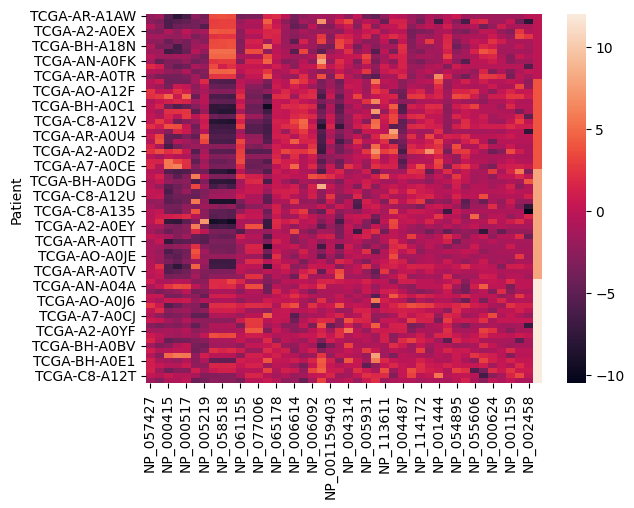

In [131]:
processed_p50_plot.index.name = 'Patient'
sb.heatmap(processed_p50_plot) ## The x-axis are the PAM50 proteins we used and the right-most column is the cluster marker
plt.savefig('cluster.png')
## Looks like the clustering works quite decently here!

## Each cluster means a different molecular signature for each patient. Such patients have different treatment options available
## to them!


In [ ]:
# Part added by Pietro Gavazzi

<AxesSubplot:>

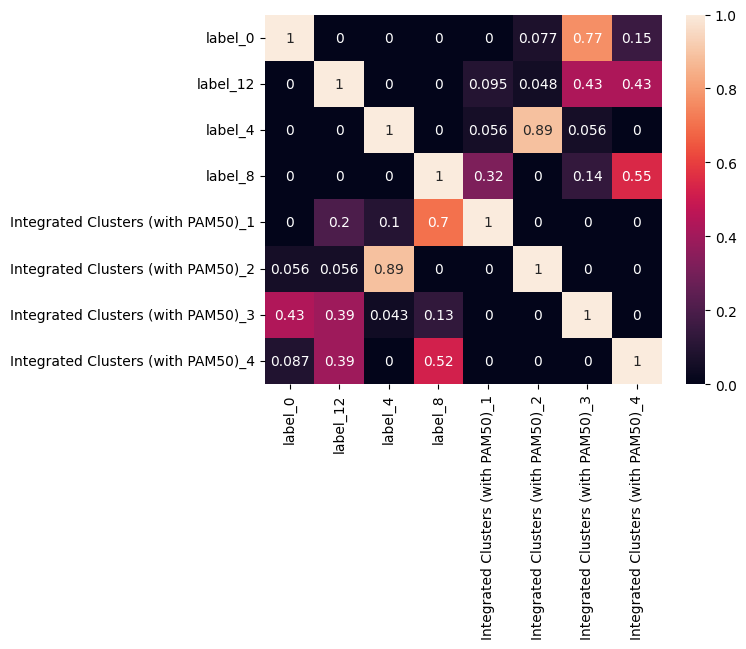

In [132]:
# https://www.docteur-eric-sebban.fr/cancer-du-sein/diagnostic-cancer-sein/stades-et-types-de-cancer-du-sein/ 


# «T» pour la taille et l’infiltration de la tumeur, allant de Tx (tumeur non évaluable) à T4.
# «N» pour le degré d’envahissement des ganglions lymphatiques, allant de Nx (envahissement des ganglions non évaluable) à N3.




dataf = pd.DataFrame({ "label":clusterer_final.labels_}, index=processed.index, dtype=str)
dataf = pd.get_dummies(dataf)
tbm = pd.get_dummies(processed, columns=["Integrated Clusters (with PAM50)"]).T.loc[["Integrated Clusters (with PAM50)_1", "Integrated Clusters (with PAM50)_2", "Integrated Clusters (with PAM50)_3", "Integrated Clusters (with PAM50)_4"]].T
dataf = dataf.merge(tbm, left_index=True,right_index=True)
matrix = np.zeros((len(dataf.T), len(dataf.T)))

indi = 0
for i in dataf.T.index:
    indj = 0
    for j in dataf.T.index:
        matrix[indi][indj]+=np.array(dataf[i])@np.array(dataf[j])
        indj+=1
    indi+=1


for i in range(len(matrix)):
    matrix[i]/=matrix[i][i]

sb.heatmap(matrix, xticklabels=dataf.columns, yticklabels=dataf.columns, annot=True)

,Integrated Clusters (no exp)_1,Integrated Clusters (no exp)_2,Integrated Clusters (no exp)_3,Integrated Clusters (no exp)_4
TCGA-A2-A0CM,1,0,0,0
TCGA-A2-A0D2,0,1,0,0
TCGA-A2-A0EQ,1,0,0,0
TCGA-A2-A0EV,0,0,1,0
TCGA-A2-A0EX,1,0,0,0
...,...,...,...,...
TCGA-C8-A138,0,0,1,0
TCGA-D8-A142,0,1,0,0
TCGA-E2-A154,0,0,1,0
TCGA-E2-A158,0,1,0,0
